# Model Development: Airline Delay
<img src="../assets/airline-pic.jpg" alt="Title-Pic">

# Imports

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from datetime import datetime
from pandas import Series, DataFrame
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (10, 6), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})
warnings.filterwarnings('ignore')

# Data

In [37]:
def export_model(model, model_name):
    timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")
    export_path = f"../trained_models/{timestamp_string}_{model_name}"
    with open(export_path, "wb") as model_file:
        pickle.dump(model, model_file)
    
    return export_path

In [38]:
def load_model(model_path):
    with open(model_path, "rb") as model_file:
        return pickle.load(model_file)

In [39]:
def print_top_rankings(grid_model, top=10):
    sorted_zipped_report = sorted(
        zip(
            grid_model.cv_results_["params"], 
            grid_model.cv_results_["mean_test_score"], 
            grid_model.cv_results_["rank_test_score"]
        ), key=lambda item: item[2]
    )
    for (i, (params, score, rank)) in enumerate(sorted_zipped_report):
        if i >= top:
            break

        print(f"Rank: {rank}\tScore: {score}\nParam: {params}\n")

def print_model_classification_report(model, X_data, y_data):
    preds_test = model.predict(X_data)
    preds_train = model.predict(X_train)

    f1_score_test = f1_score(y_data, preds_test, average="macro")
    accuracy_score_test = accuracy_score(y_data, preds_test)
    f1_score_train = f1_score(y_train, preds_train, average="macro")
    accuracy_score_train = accuracy_score(y_train, preds_train)

    print(f"Accuracy-Score:\t{accuracy_score_test}\t|\tTrain-Accuracy-Score:\t{accuracy_score_train}")
    print(f"F1-Score:\t{f1_score_test}\t|\tTrain-F1-Score:\t\t{f1_score_train}\n")
    print(classification_report(y_data, preds_test))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_data, preds_test), annot=True, cmap="cool", fmt='.5g')

# def print_feature_importance(model):
#     return Series(data=model.feature_importances_, index=DATA_COLUMN_NAMES).sort_values(ascending=False)

In [40]:
MODEL_DATA = np.load("../model_data/nasa_prep_data.npz", allow_pickle=True)
inputs = MODEL_DATA["inputs"]
targets = MODEL_DATA["targets"]

X_train, X_tmp_test, y_train, y_tmp_test = train_test_split(inputs, targets, test_size=0.4, random_state=101)
X_test, X_val, y_test, y_val = train_test_split(X_tmp_test, y_tmp_test, test_size=0.5, random_state=101)

(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((358942, 613), (119648, 613), (119648, 613)),
 ((358942,), (119648,), (119648,)))

# Build the Model

## Model1: Gradient Boosting

Accuracy-Score:	0.6600611794597486	|	Train-Accuracy-Score:	0.6849658162042893
F1-Score:	0.6593442253973831	|	Train-F1-Score:		0.6842757431528375

              precision    recall  f1-score   support

           0       0.65      0.71      0.67     59699
           1       0.68      0.61      0.64     59949

    accuracy                           0.66    119648
   macro avg       0.66      0.66      0.66    119648
weighted avg       0.66      0.66      0.66    119648



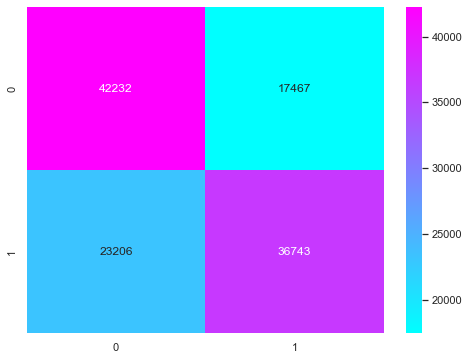

In [41]:
xgb_model = XGBClassifier(gamma=0.4, n_estimators=200, learning_rate=0.08, max_depth=10, min_child_weight=1.5)
xgb_model.fit(X_train, y_train)
print_model_classification_report(xgb_model, X_test, y_test)

In [42]:
xgb_tmp_model = XGBClassifier()

xgb_grid_params = {
    "eval_metric": ["logloss"],
    "n_estimators": [700, 900],
    #"learning_rate": [0.01],
    "min_child_weight": [3, 8],
    "eta": [0.01],             # learning rate
    #"gamma": [6],
    "subsample": [0.5, 0.7],
    "max_depth": [4, 10],
    "colsample_bytree": [0.5]
}

xgb_grid_model = GridSearchCV(xgb_tmp_model, xgb_grid_params, cv=2, verbose=3, scoring="f1_macro")

xgb_grid_model.fit(X_train, y_train);

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END colsample_bytree=0.5, eta=0.01, eval_metric=logloss, max_depth=4, min_child_weight=3, n_estimators=700, subsample=0.5;, score=0.637 total time= 3.2min
[CV 2/2] END colsample_bytree=0.5, eta=0.01, eval_metric=logloss, max_depth=4, min_child_weight=3, n_estimators=700, subsample=0.5;, score=0.636 total time= 3.4min
[CV 1/2] END colsample_bytree=0.5, eta=0.01, eval_metric=logloss, max_depth=4, min_child_weight=3, n_estimators=700, subsample=0.7;, score=0.637 total time= 3.4min
[CV 2/2] END colsample_bytree=0.5, eta=0.01, eval_metric=logloss, max_depth=4, min_child_weight=3, n_estimators=700, subsample=0.7;, score=0.636 total time= 3.2min
[CV 1/2] END colsample_bytree=0.5, eta=0.01, eval_metric=logloss, max_depth=4, min_child_weight=3, n_estimators=900, subsample=0.5;, score=0.639 total time= 4.2min
[CV 2/2] END colsample_bytree=0.5, eta=0.01, eval_metric=logloss, max_depth=4, min_child_weight=3, n_estimators=900, su

In [43]:
xgb_grid_model.best_params_

{'colsample_bytree': 0.5,
 'eta': 0.01,
 'eval_metric': 'logloss',
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 900,
 'subsample': 0.7}

Accuracy-Score:	0.659292257288045	|	Train-Accuracy-Score:	0.6733845579508667
F1-Score:	0.6586196210329822	|	Train-F1-Score:		0.6727021367344888

              precision    recall  f1-score   support

           0       0.65      0.71      0.67     59699
           1       0.68      0.61      0.64     59949

    accuracy                           0.66    119648
   macro avg       0.66      0.66      0.66    119648
weighted avg       0.66      0.66      0.66    119648



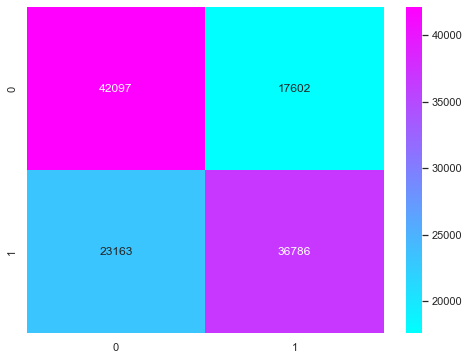

In [44]:
print_model_classification_report(xgb_grid_model.best_estimator_, X_test, y_test)

In [45]:
print_top_rankings(xgb_grid_model, top=10)

Rank: 1	Score: 0.6538728131362775
Param: {'colsample_bytree': 0.5, 'eta': 0.01, 'eval_metric': 'logloss', 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 900, 'subsample': 0.7}

Rank: 2	Score: 0.6531155930053437
Param: {'colsample_bytree': 0.5, 'eta': 0.01, 'eval_metric': 'logloss', 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 900, 'subsample': 0.5}

Rank: 3	Score: 0.652518580630272
Param: {'colsample_bytree': 0.5, 'eta': 0.01, 'eval_metric': 'logloss', 'max_depth': 10, 'min_child_weight': 8, 'n_estimators': 900, 'subsample': 0.7}

Rank: 4	Score: 0.6523281690601475
Param: {'colsample_bytree': 0.5, 'eta': 0.01, 'eval_metric': 'logloss', 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 700, 'subsample': 0.7}

Rank: 5	Score: 0.6518316697426063
Param: {'colsample_bytree': 0.5, 'eta': 0.01, 'eval_metric': 'logloss', 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 700, 'subsample': 0.5}

Rank: 6	Score: 0.6516439499651379
Param: {'colsample_bytree': 0.5, 'eta

## Model2: RandomForest

Accuracy-Score:	0.6272231880181867	|	Train-Accuracy-Score:	0.861504087011272
F1-Score:	0.6271818426123749	|	Train-F1-Score:		0.8615037051706597

              precision    recall  f1-score   support

           0       0.62      0.64      0.63     59699
           1       0.63      0.62      0.62     59949

    accuracy                           0.63    119648
   macro avg       0.63      0.63      0.63    119648
weighted avg       0.63      0.63      0.63    119648



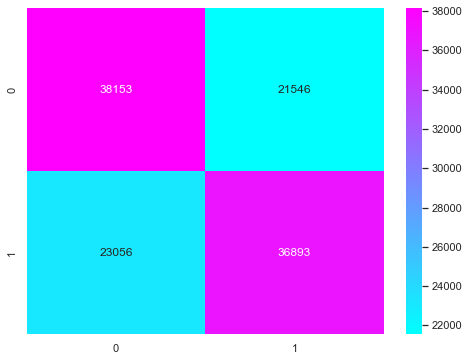

In [46]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
print_model_classification_report(rf_model, X_test, y_test)

In [47]:
rf_tmp_model = RandomForestClassifier()

rf_grid_params = {
    "criterion": ["gini"],
    "max_depth": [50, 90],
    "min_samples_split": [3, 7],
    "min_samples_leaf": [3, 7],
    "n_estimators": [500, 700],
    "max_samples": [0.9],
    "bootstrap": [True]
}

rf_grid_model = GridSearchCV(rf_tmp_model, rf_grid_params, cv=2, scoring="f1_macro", verbose=3)

rf_grid_model.fit(X_train, y_train);

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=50, max_samples=0.9, min_samples_leaf=3, min_samples_split=3, n_estimators=500;, score=0.652 total time= 3.7min
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=50, max_samples=0.9, min_samples_leaf=3, min_samples_split=3, n_estimators=500;, score=0.650 total time= 3.8min
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=50, max_samples=0.9, min_samples_leaf=3, min_samples_split=3, n_estimators=700;, score=0.653 total time= 5.2min
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=50, max_samples=0.9, min_samples_leaf=3, min_samples_split=3, n_estimators=700;, score=0.650 total time= 5.2min
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=50, max_samples=0.9, min_samples_leaf=3, min_samples_split=7, n_estimators=500;, score=0.652 total time= 3.8min
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=50, max_samples=0.9, min_samples_leaf=3, min_samp

In [54]:
rf_grid_model.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 90,
 'max_samples': 0.9,
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'n_estimators': 500}

Accuracy-Score:	0.6603537041989836	|	Train-Accuracy-Score:	0.7370745134311393
F1-Score:	0.6600805066044999	|	Train-F1-Score:		0.7368931096300901

              precision    recall  f1-score   support

           0       0.65      0.69      0.67     59699
           1       0.67      0.63      0.65     59949

    accuracy                           0.66    119648
   macro avg       0.66      0.66      0.66    119648
weighted avg       0.66      0.66      0.66    119648



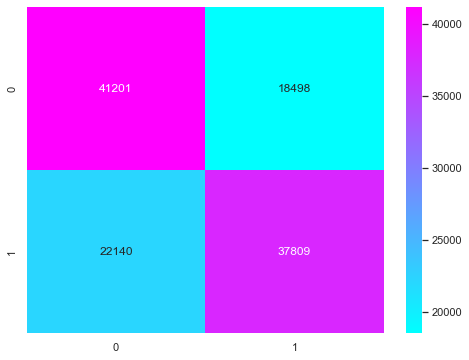

In [52]:
print_model_classification_report(rf_grid_model.best_estimator_, X_test, y_test)

In [53]:
print_top_rankings(rf_grid_model, top=10)

Rank: 1	Score: 0.653005944919909
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_samples': 0.9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 500}

Rank: 2	Score: 0.6528541721157683
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_samples': 0.9, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 500}

Rank: 3	Score: 0.6528379622311998
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_samples': 0.9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 700}

Rank: 4	Score: 0.6527892544439368
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_samples': 0.9, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 700}

Rank: 5	Score: 0.6517343784072159
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 50, 'max_samples': 0.9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 700}

Rank: 6	Score: 0.6516974693214218
Param: {'bootstrap': True, 

# Final Model Selection

## Model Validation

Accuracy-Score:	0.6606713024872961	|	Train-Accuracy-Score:	0.6849658162042893
F1-Score:	0.6598430530383959	|	Train-F1-Score:		0.6842757431528375

              precision    recall  f1-score   support

           0       0.65      0.71      0.68     60023
           1       0.68      0.61      0.64     59625

    accuracy                           0.66    119648
   macro avg       0.66      0.66      0.66    119648
weighted avg       0.66      0.66      0.66    119648

Accuracy-Score:	0.6593340465365071	|	Train-Accuracy-Score:	0.6733845579508667
F1-Score:	0.6585437943728585	|	Train-F1-Score:		0.6727021367344888

              precision    recall  f1-score   support

           0       0.65      0.71      0.67     60023
           1       0.67      0.61      0.64     59625

    accuracy                           0.66    119648
   macro avg       0.66      0.66      0.66    119648
weighted avg       0.66      0.66      0.66    119648

Accuracy-Score:	0.629789047873763	|	Train-Accuracy-Sco

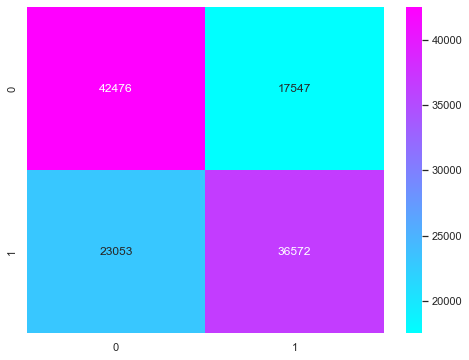

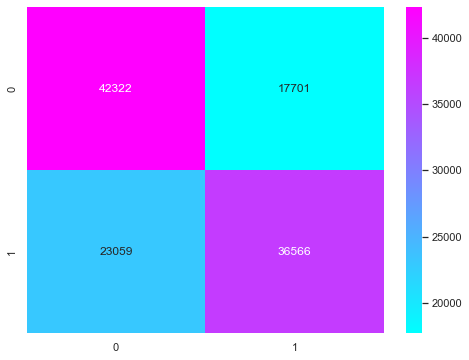

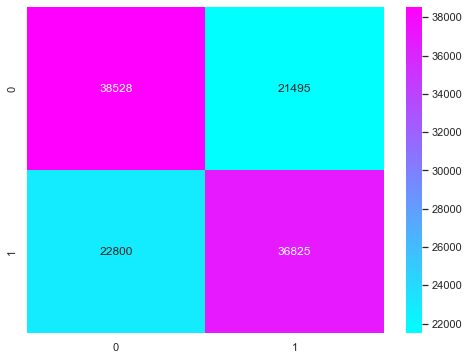

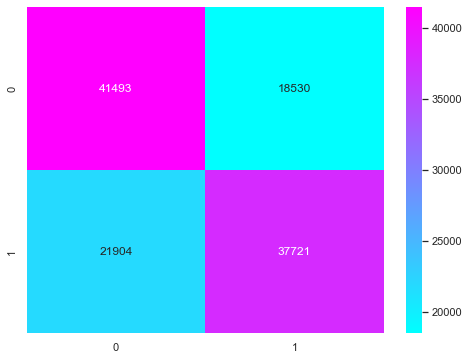

In [55]:
print_model_classification_report(xgb_model, X_val, y_val)
print_model_classification_report(xgb_grid_model.best_estimator_, X_val, y_val)
print_model_classification_report(rf_model, X_val, y_val)
print_model_classification_report(rf_grid_model.best_estimator_, X_val, y_val)

## Model Selection

In [56]:
final_model = xgb_model
# good balance. Not overfitted that much and good accuracy